# Comparing to Measurements: Quality Controlling and Gap Filling Measurements with Solcast Actuals

In this real-world example we are going to use Historic data from the Solcast API to perform quality assurance on some measurement data. The measurements data used in the exercise is a re-worked time-series sourced from the Fort Peck, Montana SURFRAD site.

We will be using some external libraries for this task, in particular [Pvanalytics](https://pvanalytics.readthedocs.io/en/stable/), an industry standard when it comes to PV analytics, and [Plotly](https://plotly.com/python/), a common Python plotting library.

In [1]:
# ! pip install plotly pvanalytics

In [2]:
import numpy as np
import pandas as pd

import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

from pvanalytics import quality

# retrieve relevant Solcast data
from solcast import historic



## Fetch Data

Here we have we have 15 minute measurements, labelled with period_end, at UTC-7.

If you need to align the timezone and period of your measurement data, check out `3.1 Comparing to Measurements: Timezone and Time Period alignment.ipynb`

In [3]:
measurements = pd.read_csv("3.2_sample_measurements.csv", index_col=0, parse_dates=True)
measurements.head()
measurements.tail()

,ghi
period_end,
2021-06-04 23:00:00-07:00,0.0
2021-06-04 23:15:00-07:00,0.0
2021-06-04 23:30:00-07:00,0.0
2021-06-04 23:45:00-07:00,0.0
2021-06-05 00:00:00-07:00,0.0


In [4]:

# NOTE: this will consume an API request!
resp = historic.radiation_and_weather(
    latitude=48.30783,
    longitude=-105.1017,
    output_parameters=["ghi", "clearsky_ghi", "zenith"],
    start="2021-06-03 00:00:00-07:00",
    end="2021-06-05 00:00:00-07:00",
    period="PT15M",
)
solcast = resp.to_pandas()
# convert to UTC-7 to compare to measurements
solcast.index = solcast.index.tz_convert("-07:00:00")  

solcast.head()

,ghi,clearsky_ghi,zenith
period_end,,,
2021-06-03 00:15:00-07:00,0,0,110
2021-06-03 00:30:00-07:00,0,0,109
2021-06-03 00:45:00-07:00,0,0,109
2021-06-03 01:00:00-07:00,0,0,109
2021-06-03 01:15:00-07:00,0,0,108


,ghi_solcast,clearsky_ghi_solcast,zenith_solcast,ghi_meas
period_end,,,,
2021-06-03 00:15:00-07:00,0,0,110,0.0
2021-06-03 00:30:00-07:00,0,0,109,0.0
2021-06-03 00:45:00-07:00,0,0,109,0.0
2021-06-03 01:00:00-07:00,0,0,109,0.0
2021-06-03 01:15:00-07:00,0,0,108,0.0


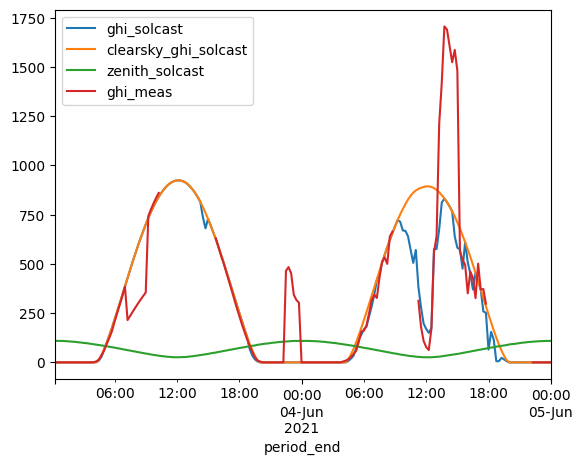

In [5]:
df = solcast.add_suffix("_solcast").join(measurements.add_suffix("_meas"))
df.plot()
display(df.head())

## Missing and Stale data
A common issue with measurement data is to have an incomplete time series with missing or stale data. We can identify gaps and stale sequences in our data using pvanalytics [quality.gaps.stale_values_diff](https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.gaps.stale_values_diff.html). Once identified we can fill or replace their values with Solcast API"s Historial actuals.

In [6]:
missing = df["ghi_meas"].isnull()
# only check sun-up periods for staleness (expecting zeros at nighttime!)
stale = quality.gaps.stale_values_diff(df["ghi_meas"].where(df["zenith_solcast"] < 88), mark="all")
df["missing_or_stale"] =  missing | stale

# make a quality-controlled GHI
df["ghi_QC"] = df["ghi_meas"].mask(df["missing_or_stale"], df["ghi_solcast"])

Let's plot the results. The dashed line represents where we filled missing measurement data with Solcast"s Historical data.

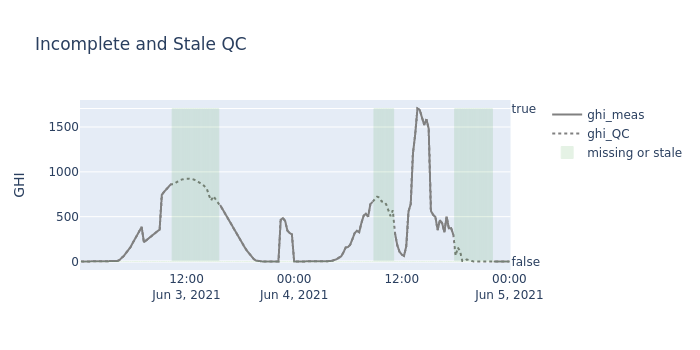

In [7]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_meas"], name="ghi_meas", marker=dict(color="grey")),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_QC"], name="ghi_QC", marker=dict(color="grey"), line=dict(dash="dot")),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(
        x=df.index, 
        y=df["missing_or_stale"], 
        name="missing or stale", 
        marker_line_width=1, 
        marker_color="green",
        marker_line_color="green",
        opacity=0.1
    ),
    secondary_y=True,
)

fig.update_layout(autosize=False, width=700, height=350, title="Incomplete and Stale QC")
fig.update_yaxes(title_text="GHI", secondary_y=False)
fig.show()

## Non-Physical Values
A common way to flag anomalous values is to check for values that exceed the clearsky values. We will use the [clearsky_limits](https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.irradiance.clearsky_limits.html#pvanalytics.quality.irradiance.clearsky_limits) function from `pvanalytics` with clearsky values from the Solcast API.

In [8]:
# check we do not exceed clearsky irradiance during the day 
df["non_physical"] = ~quality.irradiance.clearsky_limits(
    df["ghi_QC"], df["clearsky_ghi_solcast"], csi_max=1.2
) & (df["zenith_solcast"] < 88)

# cloud enhancement can temporarily exceed clearsky limits (especially on a 5min scale)
# so check that there is at least two contiguous timesteps
df["non_physical"] = ( 
    (df["non_physical"] & df["non_physical"].shift(1))
    | (df["non_physical"] & df["non_physical"].shift(-1))
)

# night time
df["non_physical"] = df["non_physical"] | (
    (df["ghi_meas"] > 0) & (df["clearsky_ghi_solcast"] == 0) & (df["zenith_solcast"] > 95)
)

# replace non physical data with Solcast GHI
df["ghi_QC"] = df["ghi_QC"].mask(df["non_physical"], other=df["ghi_solcast"])

Let's plot the results to see where we have flagged values

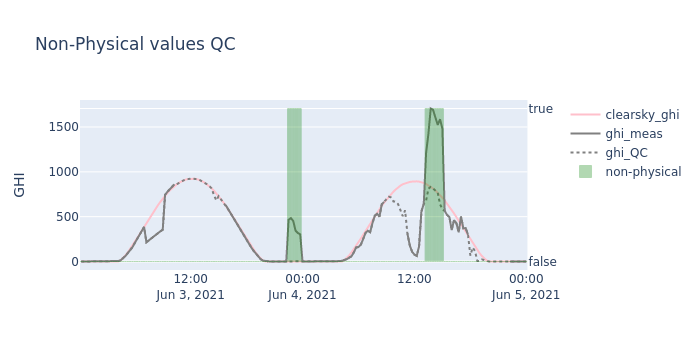

In [9]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df["clearsky_ghi_solcast"], name="clearsky_ghi", marker=dict(color="pink")),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_meas"], name="ghi_meas", marker=dict(color="grey")),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_QC"], name="ghi_QC", marker=dict(color="grey"), line=dict(dash="dot")),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(
        x=df.index, 
        y=df["non_physical"], 
        name="non-physical", 
        marker_line_width=1, 
        opacity=0.3, 
        marker_color="green",
        marker_line_color="green"
    ),
    secondary_y=True,
)

fig.update_layout(
    title_text="Non-Physical values QC", autosize=False, width=700, height=350
)
fig.update_yaxes(title_text="GHI", secondary_y=False)
fig.show()

## Manual Flagging

There are unlimited ways for measurement data to be wrong - and no automated check can get all of them. Some times, data needs to be manually flagged - or you may have flags coming from other systems that you want to apply.

In [10]:
# Here we have some corrupt measurement data, for example due to dodgy pyanometer averaging.
df["manual_bad_flag"] = False
df.loc[slice("2021-06-03 07:15", "2021-06-03 09:00"), "manual_bad_flag"] = True

# replace manually with Solcast GHI
df["ghi_QC"] = df["ghi_QC"].mask(df["manual_bad_flag"], other=df["ghi_solcast"])

Plotting up the results:

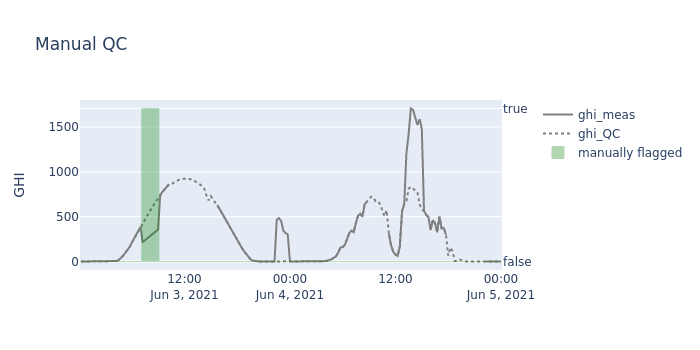

In [11]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_meas"], name="ghi_meas", marker=dict(color="grey")),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_QC"], name="ghi_QC", marker=dict(color="grey"), line=dict(dash="dot")),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(
        x=df.index, 
        y=df["manual_bad_flag"], 
        name="manually flagged", 
        marker_line_width=1, 
        opacity=0.3, 
        marker_color="green",
        marker_line_color="green"
    ),
    secondary_y=True,
)

fig.update_layout(
    title_text="Manual QC", autosize=False, width=700, height=350
)
fig.update_yaxes(title_text="GHI", secondary_y=False)
fig.show()

## Overall Visualisation

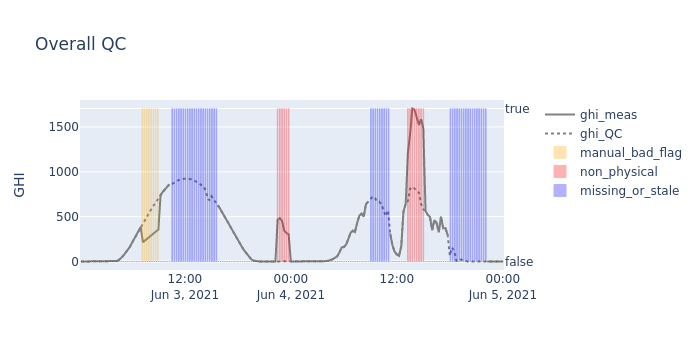

In [12]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_meas"], name="ghi_meas", marker=dict(color="grey")),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df["ghi_QC"], name="ghi_QC", marker=dict(color="grey"), line=dict(dash="dot")),
    secondary_y=False,
)

for qc_col, color in [
    ("manual_bad_flag", "orange"),
    ("non_physical", "red"),
    ("missing_or_stale", "blue"),
]:
    fig.add_trace(
        go.Bar(
            x=df.index, 
            y=df[qc_col], 
            name=qc_col, 
            marker_line_width=1, 
            opacity=0.3, 
            marker_color=color,
            marker_line_color=color,
        ),
        secondary_y=True,
    )

fig.update_layout(
    title_text="Overall QC", autosize=False, width=700, height=350
)
fig.update_yaxes(title_text="GHI", secondary_y=False)
fig.show()